In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Data Visulaization
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.utils import resample
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize

# transferlearning using fast.ai
from fastai.text import * 
from fastai import *
from fastai.callbacks import *
from fastai.vision import *

import pickle
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    

/kaggle/input/twitter-airline-sentiment/database.sqlite
/kaggle/input/twitter-airline-sentiment/Tweets.csv


##### Reading the csv file and creating the csv file using pandas

In [2]:
df = pd.read_csv('/kaggle/input/twitter-airline-sentiment/Tweets.csv')


### Exploratory Data Analysis

Looking at the first 5 examples of the dataset.

In [3]:
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
print("Shape: ", df.shape)

Shape:  (14640, 15)


The data consists of 14640 rows and 15 columns

Checking for null values

In [5]:
#Checking for null values
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

### Understanding the Data using visulaization

Sentiment distirbution among the tweets

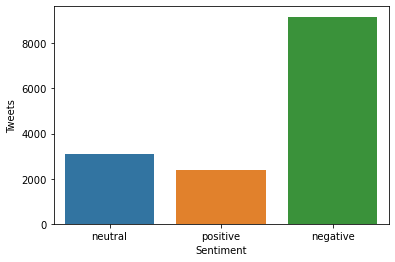

In [6]:
sns.countplot(df.airline_sentiment)
plt.xlabel('Sentiment')
plt.ylabel('Tweets')
plt.show()


Distirbution of tweets among the airlines

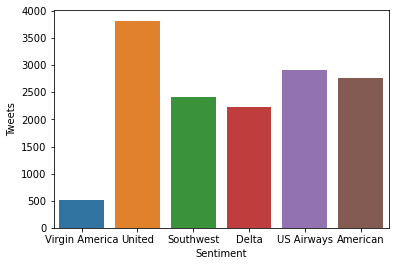

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [7]:
sns.countplot(df.airline)
plt.xlabel('Sentiment')
plt.ylabel('Tweets')
plt.show()
df['airline'].value_counts()

Understanding the distirbutions of sentiment among the different airlines

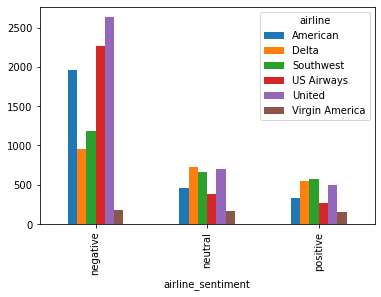

In [8]:
df.groupby(['airline_sentiment','airline']).size().unstack().plot(kind='bar')

Label encoding positive, neutral and negative sentiment as 2,1,0

In [9]:
#Label encoding
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['airline_sentiment'])
df['sentiment'].value_counts()

0    9178
1    3099
2    2363
Name: sentiment, dtype: int64

### Cleaning the text
Text cleaning includes removing the unnecessary tags, special characters etc..

In [10]:
#Removing Http tags, special characters, mentions, punctuations
def preprocessing(text):
    httptags = re.sub("r'http\S+'", " ", text)  
    characters = re.sub("[^a-zA-Z]"," ", httptags)  
    punctuation = re.sub(r'[^\w\s]',"", characters)
    mentiontags = re.sub("@\w+","",punctuation) 
    return mentiontags 

### ULMFiT Implementation
In this notebook we're implementing the bidirecrtional model, which means we are training both forward and backward language and classifier model. A forward model is regular language model which predicts the next words based on previous words, A backward model works in the same way but it predicts the previous words followed by the predicted words.



Removing the columns that aren't been used for the model. This model requires only the two main columns which are sentiment and the text(in our case tweets)

In [11]:
df = df[['text','sentiment']]
df.head()

,text,sentiment
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,2
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


In [12]:
df_ulm = df[['text','sentiment']]
df_ulm.shape

(14640, 2)

Applying the preprocessing to the tweets which cleans our text

In [13]:
df_ulm['filtered_text'] = df_ulm['text'].apply(lambda x: preprocessing(x))

In [14]:
df_ulm

,text,sentiment,filtered_text
0,@VirginAmerica What @dhepburn said.,1,VirginAmerica What dhepburn said
1,@VirginAmerica plus you've added commercials t...,2,VirginAmerica plus you ve added commercials t...
2,@VirginAmerica I didn't today... Must mean I n...,1,VirginAmerica I didn t today Must mean I n...
3,@VirginAmerica it's really aggressive to blast...,0,VirginAmerica it s really aggressive to blast...
4,@VirginAmerica and it's a really big bad thing...,0,VirginAmerica and it s a really big bad thing...
...,...,...,...
14635,@AmericanAir thank you we got on a different f...,2,AmericanAir thank you we got on a different f...
14636,@AmericanAir leaving over 20 minutes Late Flig...,0,AmericanAir leaving over minutes Late Flig...
14637,@AmericanAir Please bring American Airlines to...,1,AmericanAir Please bring American Airlines to...
14638,"@AmericanAir you have my money, you change my ...",0,AmericanAir you have my money you change my ...


In [15]:
df['text'][33]

'@VirginAmerica awaiting my return phone call, just would prefer to use your online self-service option :('

In [16]:
df_ulm['filtered_text'][33]

' VirginAmerica awaiting my return phone call  just would prefer to use your online self service option   '

Comparing the tweet after and before preprocessing.
* **Before:**   '@VirginAmerica awaiting my return phone call, just would prefer to use your online self-service option :('
* **After:**     ' VirginAmerica awaiting my return phone call  just would prefer to use your online self service option   '

Removing the unfiltered text column, as we require only filtered text column

In [17]:
del df_ulm['text']


In [18]:
df_ulm

,sentiment,filtered_text
0,1,VirginAmerica What dhepburn said
1,2,VirginAmerica plus you ve added commercials t...
2,1,VirginAmerica I didn t today Must mean I n...
3,0,VirginAmerica it s really aggressive to blast...
4,0,VirginAmerica and it s a really big bad thing...
...,...,...
14635,2,AmericanAir thank you we got on a different f...
14636,0,AmericanAir leaving over minutes Late Flig...
14637,1,AmericanAir Please bring American Airlines to...
14638,0,AmericanAir you have my money you change my ...


Splitting the DataFrame into train and test

In [19]:
split_ratio = int(len(df_ulm) * 0.75)
train_df = df_ulm[:split_ratio]
test_df = df_ulm[split_ratio:]
print("train length", len(train_df))
print("test length", len(test_df))
print("total length", sum([len(train_df),len(test_df)]))

train length 10980
test length 3660
total length 14640


In [20]:
train_df

,sentiment,filtered_text
0,1,VirginAmerica What dhepburn said
1,2,VirginAmerica plus you ve added commercials t...
2,1,VirginAmerica I didn t today Must mean I n...
3,0,VirginAmerica it s really aggressive to blast...
4,0,VirginAmerica and it s a really big bad thing...
...,...,...
10975,1,USAirways Mobile boarding pass email
10976,2,USAirways we will sunday Just a few days away
10977,1,USAirways I am following you now
10978,0,USAirways unacceptable You knew the pilot wo...


#### Building the Language Model
* The main objective of language model is to understand language and it requires modeling complex language, mostly deals with understanding problems such as translation, question answering and sentiment analysis. The key feature of language model is to predict the next words from the given previous sequence of words. It is able to do it because it is trained large data sets and so it can learn the patterns of the language in a much deeper way.
* **Example**: I want to eat hot _____ ( Obviously it would be dog)
*  With the help of the neural nets and by traning we can easily predict the next words.

#### Getting data ready for modelling
> Here I'm using from_df for the [TextLMDataBunch](http://docs.fast.ai/text.data.html#TextLMDataBunch) to get the data ready for the language model, It does most of the preprocessing behind the scene

In [21]:
#language model
data_lm = TextLMDataBunch.from_df("/kaggle/working",train_df=train_df, valid_df=test_df)

In [22]:
data_lm.save('data_lm_export.pkl')


### Creating and Fine-tuning language model
* Architecture that ULMFiT uses for it's language modeling task is AWD_LSTM which stands for ASGD Weight-Dropped LSTM. The main idea of the AWD_LSTM is to use dropout in every possible layer. It does four different kinds of dropout which is different from the usual dropouts. The detailed informstion is provided by fast.ai [documentation](https://docs.fast.ai/text.models.html)
* Next step is to fine-tune the model and do transfer learning. data_lm object which we created earlier is used to fine-tune a pretrained language model. In the next step we are creating a learner object that will directly create a model, downloads the pretrained weights and can be used for fine-tuning

In [23]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.167483,4.589505,0.187029,00:06


Fastai provides lr_find() to search through a range of learning rates to find the optimum for dataset.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


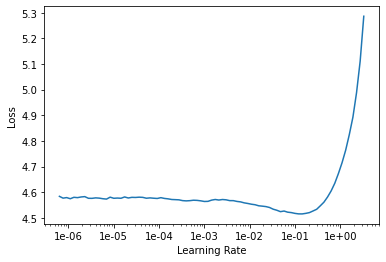

In [24]:
learn.lr_find()
learn.recorder.plot()

Alike computer vision model, we can unfreeze and fine-tune the model,  Now look at the plot of learning rate against loss and determine the lowest point (around 1e-1 for the plot below) and go back by one magnitude and choose that as a learning rate (something around 1e-2). We start training the model with learning rate 1e-2 using fit_one_cycle. First argument '3' indicates the number of epochs

In [25]:
learn.unfreeze()
learn.fit_one_cycle(3, 1e-3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.342881,4.337672,0.220945,00:07
1,4.113367,4.198363,0.237909,00:07
2,3.928080,4.172864,0.240476,00:07


To evaluate the language model, we can run learn.predict and pass in the start of the sentence and specify number of words we want to guess

In [26]:
learn.predict("American Airlines provides worst", n_words = 20)

'American Airlines provides worst customer service on TV Far most booking problems on international flight jetblue no way to go to folder'

That is pretty decent response and looks like correct grammar. After fine-tuning we get a model that’s good at understanding tweets and we can fine-tune that with transfer learning to classify tweets to be positive, neutral or negative. Let us save the encoding of the model to be used later for classification

In [27]:
learn.save_encoder('ft_enc')

### Building a classifier
Similar to language model we're building text classifier here using [TextClasDataBunch](https://docs.fast.ai/text.data.html#TextClasDataBunch). 


In [28]:
# Classifier model data
data_clas = TextClasDataBunch.from_df("/kaggle/working", train_df=train_df, valid_df=test_df,vocab=data_lm.train_ds.vocab, bs=128)

In [29]:
#Save data
data_clas.save('data_clas_export.pkl')

In [30]:
#load data
data_clas = load_data("/kaggle/working", 'data_clas_export.pkl', bs=16)

* Finally let's create a text classifier learner. We're using data_clas to build a classifier with the fine-tuned encoder.
* Earlier we saved encoding part with 'ft_enc

In [31]:
classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
classifier.load_encoder('ft_enc')


RNNLearner(data=TextClasDataBunch;

Train: LabelList (10980 items)
x: TextList
xxbos virginamerica xxmaj what xxunk said,xxbos virginamerica plus you ve added commercials to the experience xxunk,xxbos virginamerica i didn t today xxmaj must mean i need to take another trip,xxbos virginamerica it s really aggressive to xxunk obnoxious entertainment in your guests faces amp they have little recourse,xxbos virginamerica and it s a really big bad thing about it
y: CategoryList
1,2,1,0,0
Path: /kaggle/working;

Valid: LabelList (3660 items)
x: TextList
xxbos usairways xxmaj then told to xxunk because the captain was over hours xxmaj this has been a terrible experience,xxbos usairways xxmaj why were we loaded onto the plane hours xxmaj late xxmaj flight mind you made to sit for minutes,xxbos usairways why load us on the flight if the captain was over the hours he could fly in one consecutive period xxmaj unacceptable,xxbos usairways xxunk the plane xxmaj this is ridiculous,xxbos usairways xx

In [32]:
data_clas.show_batch()

text,target
xxbos southwestair xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month xxmaj months a xxmaj year xxmaj is xxmaj xxunk xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj corp xxmaj like u xxmaj in xxmaj future,2
xxbos united xxmaj well xxmaj it s xxup la and then a hr car ride to a dark xxmaj palm xxmaj springs technically xxmaj maybe i ll get bumped to st class xxmaj den to xxup phl on xxmaj friday,1
xxbos usairways not happy w app xxmaj late xxmaj flightly xxmaj last time i flew wouldn t let me check in xxmaj this time i checked in went on xxmaj late xxmaj flightr says i never checked in,0
xxbos virginamerica xxmaj because we never xxunk d xxmaj cancelled xxmaj flightlation notice we were left w no options to fly out of xxup ps xxmaj driving to xxup la for a red eye xxmaj mon w kids,0
xxbos jetblue should i be nervous about a xxmaj sunday xxup am flight xxmaj baltimore to xxmaj boston xxmaj any suggestions on what i can do xxmaj need to be in xxmaj boston by xxmaj monday,1


#### Fastai limits the vocabulary of the training data by replacing with unk tokens. From the above result, we see that a token can be recognized in the senetences.
*  **xxunk**: for unknown words,
*  **xx** : At the start of the each token
*  **xxbos**: at the begining of a sentence
*  **xxup**: If there's a sentence in caps it gets lowered and xxup token is called
*  **xxmaj**: Indicates the captialization of the word
*  **xxrep**: Indicates for repeated word

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


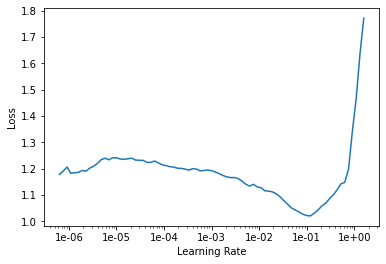

In [33]:
#learning rate
classifier.lr_find()
classifier.recorder.plot()


In [34]:
#train
classifier.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.711110,0.516373,0.800273,00:13


In [35]:
#freeze the model
classifier.freeze_to(-2)
#training for 4 epochs
classifier.fit_one_cycle(4, slice(5e-3/2., 5e-3),callbacks=[SaveModelCallback(classifier, name="best_lm")],moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.698290,0.489114,0.806557,00:14
1,0.607892,0.444287,0.821038,00:15
2,0.560847,0.416415,0.841530,00:15
3,0.487583,0.410197,0.844536,00:15


Better model found at epoch 0 with valid_loss value: 0.4891141951084137.
Better model found at epoch 1 with valid_loss value: 0.4442874491214752.
Better model found at epoch 2 with valid_loss value: 0.4164149761199951.
Better model found at epoch 3 with valid_loss value: 0.41019707918167114.


In [36]:
#unfreeze the model
classifier.unfreeze()
#train for 5 epochs
classifier.fit_one_cycle(5, slice(2e-3/100, 2e-3),callbacks=[SaveModelCallback(classifier, name="best_lm")],moms=(0.8,0.7),wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.460932,0.411469,0.843169,00:23
1,0.476697,0.421138,0.839617,00:23
2,0.439083,0.433305,0.841803,00:22
3,0.343776,0.445842,0.835246,00:24
4,0.275372,0.444930,0.838525,00:23


Better model found at epoch 0 with valid_loss value: 0.411469042301178.


In [37]:
#predicting the sentiment
predicted = classifier.predict("This was bad journey!")
print(f"Predicted Response: {list(predicted)[0]}")

Predicted Response: 0


This is predicted as '0' as negative review, which is correct.

In [38]:
#predicting the sentiment
predicted = classifier.predict("Awesome and comfortable service")
print(f"Predicted Response: {list(predicted)[0]}")

Predicted Response: 2


This is predicted as '2' as positive review, which is also correct.

### Building Backward learning Model

In [39]:
#loading the data in reverse
data_lm_back = load_data("../input/twitter-airline-sentiment", '/kaggle/working/data_lm_export.pkl', bs=128, backwards=True)

In [40]:
#display the data
data_lm_back.show_batch()

idx,text
0,customer terrible experience horrible xxmaj again usairways flying never usairways xxbos mechanical to due flight xxmaj late xxmaj hours almost was it usairways xxbos experience worse absolutely xxmaj plane the on snacks of lack and issues mechanical to due am at here still pm at dca xxup at been usairways xxbos updated passengers keep to failed pilot your that fact the correct t doesn response this usairways xxbos more no
1,xxmaj of out usairways xxbos row to s mary xxmaj bloody xxmaj send xxmaj it made usairways xxbos more twice happened has xxunk plane entire the then and once at ring phones all hear to funny xxmaj clt xxup from nyc xxup to headed usairways xxbos displeased so m i why is which trip entire an out wiped it unfortunately xxmaj phone the on handled xxmaj usairways xxbos made be
2,from plane on was xxmaj usairways xxbos computer a is get i all xxmaj menu phone the xxunk to steps exact the are what xxmaj error an xxunk dividendmiles and aa xxup merging xxmaj usairways xxbos screwed been has trip my of purpose the when today hotel pay pointless was it amp today meeting my missed i tomorrow was i usairways xxbos usairwaysfail enough good is problems xxmaj booking xxmaj
3,a have t don i but money the take you purchase a make i can how usairways xxbos mad delay hour another xxmaj row my xxmaj seat broken a had plane next the now xxmaj usairways xxbos incompetent are americanair usairways xxbos xxunk co t http experience my is here up follow to just xxmaj usairways xxbos xxunk merger the out figure ever airline worst the are u americanair usairways
4,thanks xxmaj please it retrieve to contact i do who xxmaj today flight recent a on something left i usairways xxbos now what xxmaj airport the at time no so vegas xxmaj to quickly flight a board to had we but phoenix xxmaj at landed usairways xxbos do i can what xxmaj yesterday you with flying damaged was bag my hey xxmaj usairways xxbos minutes about for me delayed you


In [41]:
#language for backward text
backward_learn = language_model_learner(data_lm_back, AWD_LSTM, drop_mult=0.5)
#train
backward_learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.587831,4.790828,0.242832,00:04


In [42]:
# train for 1 epoch
backward_learn.fit_one_cycle(1, 4e-2, moms=(0.8,0.7))
# unfreeze model 
backward_learn.unfreeze()
# training for 5 ep[ochs]
backward_learn.fit_one_cycle(5, 2e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.524027,4.351507,0.255171,00:04


epoch,train_loss,valid_loss,accuracy,time
0,4.013965,4.307347,0.259251,00:06
1,3.896775,4.191524,0.268527,00:06
2,3.747965,4.259019,0.267051,00:06
3,3.548801,4.244046,0.269333,00:06
4,3.375316,4.290808,0.268254,00:06


In [43]:
#predict the sentence in the reverse direction
backward_learn.predict("flight terrible", n_words= 10)

'flight terrible the for thanks Possible it is jetblue xxbos me'

It predicted the response from the backwards and grammer looks pretty descent.

In [44]:
#save model encoder
backward_learn.model_dir="/kaggle/working/"
backward_learn.save_encoder('bd_enc')

### Building Backward Classifier model

In [45]:
#load the data for classifier in reverse format
data_clas_back = load_data("../input/twitter-airline-sentiment", '/kaggle/working/data_clas_export.pkl', bs=16, backwards=True)


In [46]:
#display the batch
data_clas_back.show_batch()

text,target
future xxmaj in xxmaj u like xxmaj corp xxmaj for xxmaj base xxmaj xxunk xxmaj an xxmaj be xxup will xxup we xxmaj xxunk xxmaj is xxmaj year xxmaj a months xxmaj month xxmaj history xxmaj black xxmaj see xxmaj u that xxmaj fact xxmaj the xxmaj southwestair xxbos,2
kids w mon xxmaj eye red a for la xxup to driving xxmaj ps xxup of out fly to options no w left were we notice flightlation xxmaj cancelled xxmaj d xxunk never we because xxmaj virginamerica xxbos,0
it get i do how xxmaj me for pqd earn nt did flight that now xxmaj flight lh flightr xxmaj late xxmaj a to me rebooked they gate at however xxmaj ua via lh booked i united xxbos,0
point this at do to what call return no xxmaj msgs left amp airways xxmaj us xxup phl xxup called ve i friday xxmaj on phl xxup bos xxup plane on item an left i usairways xxbos,0
m san xxup it need i me w cle xxup from flight my on got never suitcase my amp house a build go to about mexico xxmaj in m i bag my is where united xxbos,0


In [47]:
#build the text classifier
backward_classifier = text_classifier_learner(data_clas_back, AWD_LSTM, drop_mult=0.5)

In [48]:
#load encoded model
backward_classifier.model_dir='/kaggle/working/'
backward_classifier.load_encoder('bd_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (10980 items)
x: TextList
xxbos virginamerica xxmaj what xxunk said,xxbos virginamerica plus you ve added commercials to the experience xxunk,xxbos virginamerica i didn t today xxmaj must mean i need to take another trip,xxbos virginamerica it s really aggressive to xxunk obnoxious entertainment in your guests faces amp they have little recourse,xxbos virginamerica and it s a really big bad thing about it
y: CategoryList
1,2,1,0,0
Path: /kaggle/working;

Valid: LabelList (3660 items)
x: TextList
xxbos usairways xxmaj then told to xxunk because the captain was over hours xxmaj this has been a terrible experience,xxbos usairways xxmaj why were we loaded onto the plane hours xxmaj late xxmaj flight mind you made to sit for minutes,xxbos usairways why load us on the flight if the captain was over the hours he could fly in one consecutive period xxmaj unacceptable,xxbos usairways xxunk the plane xxmaj this is ridiculous,xxbos usairways xx

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


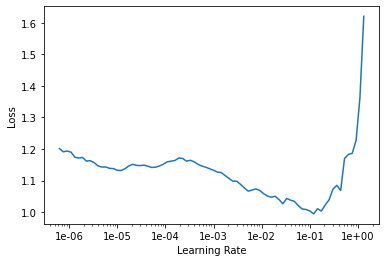

In [49]:
#learning rate
backward_classifier.lr_find()
backward_classifier.recorder.plot()


In [50]:
#train
backward_classifier.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.845516,0.536785,0.783607,00:13


In [51]:
#freeze
backward_classifier.freeze_to(-2)
#train for 4 epochs
backward_classifier.fit_one_cycle(4, slice(5e-3/2., 5e-3),callbacks=[SaveModelCallback(classifier, name="best_lm")],moms=(0.8,0.7),wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.784522,0.551008,0.798907,00:15
1,0.700054,0.453956,0.821585,00:15
2,0.660211,0.447391,0.836339,00:15
3,0.698697,0.421733,0.840710,00:14


Better model found at epoch 0 with valid_loss value: 0.44492992758750916.


In [52]:
#unfreeze and train for 4  epochs
lr = 1e-3
backward_classifier.unfreeze()
lr /= 5
backward_classifier.fit_one_cycle(4, slice(lr/(2.6**4),lr),callbacks=[SaveModelCallback(classifier, name="best_lm")], moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.625239,0.425023,0.834426,00:24
1,0.613445,0.417137,0.840984,00:24
2,0.586322,0.417382,0.841530,00:23
3,0.599769,0.416312,0.844536,00:23


Better model found at epoch 0 with valid_loss value: 0.44492992758750916.


Confusionmatrix is good technique to summarize the classification model

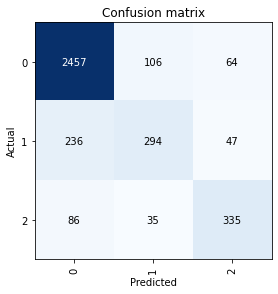

In [53]:
preds,y,losses = classifier.get_preds(with_loss=True)
interp = ClassificationInterpretation(classifier,preds,y,losses)
interp.plot_confusion_matrix()

#### Conclusion
The language modelling approach using fast.ai is the simplest and most powerful tool, I have come across. The library provides very easy to use methods and with a few lines of code, we can achieve state-of-the-art results.

#### References
* https://docs.fast.ai/text.html#Quick-Start:-Training-an-IMDb-sentiment-model-with-ULMFiT
* http://nlp.fast.ai/classification/2018/05/15/introducing-ulmfit.html
* https://course.fast.ai/videos/?lesson=12
* https://course.fast.ai/videos/?lesson=12
* https://github.com/fastai/fastai/blob/master/examples/ULMFit.ipynb